# Assignment 1 for FIT5212, Semester 1

**Student Name:**  Anh Huy Phung

**Student ID:**    34140298

In this task, I run eight configurations to perform a binary classification on the *ComputationalLinguistics* column, treating it as a 0/1 label and ignoring the other two classes for simplicity.


## Loading dataset and import library for part 1

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Run the following cmd if you have not installed torch and torchtext
# !pip install torch==2.0.0 --index-url https://download.pytorch.org/whl/cu118
# !pip install torchtext==0.15.1 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177

In [3]:
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext import data
import torch.optim as optim
import time

import csv
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef, precision_recall_curve
import seaborn as sns
import numpy as np

import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


## Part 1:  Text Classification



In this task, I removed only *stopwords*, as they offer little semantic value and tend to introduce noise. Since both the *title* and *abstract* are short and centered on key concepts, preserving full word forms is important. I avoided stemming and lemmatization to retain meaningful variations in academic language—terms like *learn, learning, and learned* may reflect different contexts or stages of a concept. Reducing them to a root form could weaken interpretability and reduce classification accuracy.

Below code defines a preprocessing pipeline for text data. It includes a customizable *tokenize_text* function that can remove stopwords and return either tokens or joined text. The *load_data* function reads a CSV file, processes text from a specified column using the tokenizer and extracts labels.

In [5]:
#  lots of Python code here
tokenizer = get_tokenizer('basic_english')

# Ensure required NLTK resources are available
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
def tokenize_text(text, remove_stopwords=False, lemmatize=False, stem=False, pre_process=False, is_return_text=False):
    # Tokenize the text
    tokens = tokenizer(text)

    # Preprocess = remove stopwords and keep only alphabetic tokens
    if pre_process or remove_stopwords:
        tokens = [t for t in tokens if t not in stop_words and t.isalpha()]

    # Lemmatization
    if lemmatize:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # Stemming
    if stem:
        tokens = [stemmer.stem(t) for t in tokens]

    if is_return_text:
        return ' '.join(tokens)

    return tokens


def load_data(file_path, col_name, label_name=None, remove_stopwords=True, lemmatize=False, stem=False):
    """
    Load and preprocess text data from a CSV file. Always processes the text using tokenize_text.

    Parameters:
    - file_path (str): Path to the CSV file.
    - col_name (str): Column name containing the text.
    - label_name (str, optional): Column name for the label. If None, labels are not used.
    - remove_stopwords (bool): Whether to remove stopwords.
    - lemmatize (bool): Whether to apply lemmatization.
    - stem (bool): Whether to apply stemming.

    Returns:
    - pd.DataFrame: DataFrame with columns ['label', 'processed_text'] or ['original_text', 'processed_text']
    """
    data = []

    with open(file_path, 'r', newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        headers = next(reader)

        col_index = headers.index(col_name)
        label_index = headers.index(label_name) if label_name else None

        for row in reader:
            text = row[col_index].strip()
            processed_text = tokenize_text(
                text,
                remove_stopwords=remove_stopwords,
                lemmatize=lemmatize,
                stem=stem,
                is_return_text=True
            )

            if label_name:
                label = int(row[label_index])
                data.append((label, processed_text))
            else:
                data.append((text, processed_text))

    if label_name is None:
        return pd.DataFrame(data, columns=['text', 'processed_text'])
    return data

In [7]:
# train_url = '/content/drive/MyDrive/FIT5212/Ass1/Dataset_Assignment1/train_set.csv'
# dev_url = '/content/drive/MyDrive/FIT5212/Ass1/Dataset_Assignment1/dev_set.csv'
# test_url = '/content/drive/MyDrive/FIT5212/Ass1/Dataset_Assignment1/test_set.csv'
train_url = 'train_set.csv'
dev_url = 'dev_set.csv'
test_url = 'test_set.csv'


train_title_comp_data = load_data(train_url, 'title', 'ComputationalLinguistics', remove_stopwords=True, lemmatize=False, stem=False)
dev_title_comp_data = load_data(dev_url, 'title', 'ComputationalLinguistics', remove_stopwords=True, lemmatize=False, stem=False)
test_title_comp_data = load_data(test_url, 'title', 'ComputationalLinguistics', remove_stopwords=True, lemmatize=False, stem=False)


train_abs_comp_data = load_data(train_url, 'abstract', 'ComputationalLinguistics', remove_stopwords=True, lemmatize=False, stem=False)
dev_abs_comp_data = load_data(dev_url, 'abstract', 'ComputationalLinguistics', remove_stopwords=True, lemmatize=False, stem=False)
test_abs_comp_data = load_data(test_url, 'abstract', 'ComputationalLinguistics', remove_stopwords=True, lemmatize=False, stem=False)

In [8]:
print(f'Number of training examples: {len(train_title_comp_data)}')
print(f'Number of validation examples: {len(dev_title_comp_data)}')
print(f'Number of testing examples: {len(test_title_comp_data)}')

Number of training examples: 217058
Number of validation examples: 27132
Number of testing examples: 27133


After loading the data of both *abstract* and *title*, I will visualize the word frequency distribution and determine an appropriate cutoff point based on percentiles.

Total number of tokens: 1485660
Keeping tokens with frequency between 1.00 and 446.00


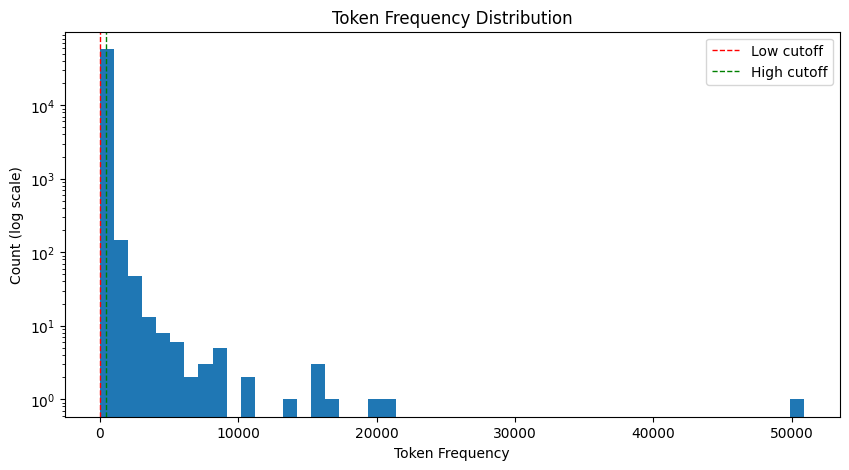

Percentiles (Token Frequency):
10th percentile: 1.00
15th percentile: 1.00
20th percentile: 1.00
25th percentile: 1.00
30th percentile: 1.00
35th percentile: 1.00
40th percentile: 1.00
45th percentile: 1.00
50th percentile: 1.00
55th percentile: 1.00
60th percentile: 1.00
65th percentile: 2.00
70th percentile: 2.00
75th percentile: 3.00
80th percentile: 5.00
85th percentile: 8.00
90th percentile: 17.00
95th percentile: 57.00


In [9]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt


def yield_tokens(data_iter, frequent_tokens = None):
    for _, text in data_iter:
        tokens = tokenizer(text)
        if frequent_tokens is not None:
          yield [t for t in tokens if t in frequent_tokens]
        else:
          yield tokenizer(text)



# Step 1: Count token frequencies
token_counts = Counter()
for tokens in yield_tokens(train_title_comp_data):
    token_counts.update(tokens)

# Step 2: Calculate frequency percentiles
frequencies = np.array(list(token_counts.values()))
low_percentile = 10   # remove bottom 10% of rare tokens
high_percentile = 99  # optionally remove top 1% most common tokens

low_cutoff = np.percentile(frequencies, low_percentile)
high_cutoff = np.percentile(frequencies, high_percentile)

total_tokens = sum(token_counts.values())
print(f"Total number of tokens: {total_tokens}")
print(f"Keeping tokens with frequency between {low_cutoff:.2f} and {high_cutoff:.2f}")

# Optional: visualize frequency distribution
plt.figure(figsize=(10, 5))
plt.hist(frequencies, bins=50, log=True)
plt.axvline(low_cutoff, color='red', linestyle='dashed', linewidth=1, label='Low cutoff')
plt.axvline(high_cutoff, color='green', linestyle='dashed', linewidth=1, label='High cutoff')
plt.title("Token Frequency Distribution")
plt.xlabel("Token Frequency")
plt.ylabel("Count (log scale)")
plt.legend()
plt.show()

# Step 3: Calculate and print percentiles from 10 to 90 (step 10)
print("Percentiles (Token Frequency):")
for p in range(10, 100, 5):
    cutoff = np.percentile(frequencies, p)
    print(f"{p}th percentile: {cutoff:.2f}")

Based on the percentile distribution, I set the cutoff at a token frequency of 90 (frequency 17) to filter out extremely rare and overly common tokens. This ensures a more balanced and meaningful vocabulary for RNN vocab modeling.

In [10]:
cutoff_75 = np.percentile(frequencies, 90)
print(f"90th percentile frequency cutoff: {cutoff_75:.2f}")
frequent_tokens = [token for token, freq in token_counts.items() if freq > cutoff_75]

vocab = build_vocab_from_iterator(
    yield_tokens(train_title_comp_data, frequent_tokens),
    specials=["<unk>"]
)

vocab.set_default_index(vocab["<unk>"])

vocab_size = len(set(list(vocab.get_itos())))
print(f"Unique tokens in TEXT vocabulary: {vocab_size}")

90th percentile frequency cutoff: 17.00
Unique tokens in TEXT vocabulary: 5751


In [11]:
# Print the top 20 most common words in the vocabulary
top_n = 20
common_vocab = list(vocab.get_itos())[:top_n]
print(f"Top {top_n} most common words in the vocabulary: {common_vocab}")

Top 20 most common words in the vocabulary: ['<unk>', 'learning', 'neural', 'models', 'using', 'deep', 'language', 'networks', 'data', 'via', 'model', 'machine', 'detection', 'network', 'graph', 'large', 'reinforcement', 'classification', 'analysis', 'prediction']


In [12]:
# Data processing
def text_pipeline(x):
    return vocab(tokenizer(x)) # return index of vocab

def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list, padding_value=vocab["<unk>"])

## Part 2. Create the Dataset and DataLoader


Due to Google Colab’s runtime constraints—and after testing several subsets—I used only 10% of the original training data to ensure reasonable training time per epoch. In this context, “full training data” refers to this 10% subset. I also apply the code from tutorials for using torch to create TextDataset and DataLoader for RNN training preparation.

In [13]:
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [14]:
# Create TextDataset instances for abstract data
train_abs_dataset = TextDataset(train_abs_comp_data)  # Use abstract data for training
test_abs_dataset = TextDataset(test_abs_comp_data)    # Use abstract data for testing
validation_abs_dataset = TextDataset(dev_abs_comp_data)  # Use abstract data for validation

# Create TextDataset instances
train_title_dataset = TextDataset(train_title_comp_data)  # Use title data for training
test_title_dataset = TextDataset(test_title_comp_data)    # Use title data for testing
validation_title_dataset = TextDataset(dev_title_comp_data)  # Use title data for validation



In [15]:
# Ensure reproducibility
np.random.seed(42)
# Function to get DataLoader for the first 1000 cases or the full dataset
def get_dataloader(dataset, batch_size=32, shuffle=True, collate_fn=None, num_samples=None):
    """
    Function to get a DataLoader for a given dataset.
    If `num_samples` is provided, it will use only the first `num_samples` from the dataset.

    Args:
        dataset: The dataset to load.
        batch_size: The batch size to use in DataLoader.
        shuffle: Whether to shuffle the data (for training set).
        collate_fn: The function to collate data into batches.
        num_samples: Number of samples to use from the dataset (None for full dataset).

    Returns:
        A DataLoader instance for the dataset.
    """
    # Slice the dataset if num_samples is specified
    if num_samples is not None:
        dataset = dataset[:num_samples]

    # Create DataLoader
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)


def get_random_subset_dataloader(dataset, batch_size=32, shuffle=True, collate_fn=None, subset_percentage=0.5):
    """
    Function to get a DataLoader for a random subset (50% by default) of the dataset.
    If `subset_percentage` is provided, it will randomly select that percentage of the dataset.

    Args:
        dataset: The dataset to load.
        batch_size: The batch size to use in DataLoader.
        shuffle: Whether to shuffle the data (for training set).
        collate_fn: The function to collate data into batches.
        subset_percentage: The percentage of the dataset to randomly select (default is 50%).

    Returns:
        A DataLoader instance for the random subset of the dataset.
    """
    # Get the indices of the full dataset
    indices = list(range(len(dataset)))

    # Shuffle the indices if shuffle is True
    if shuffle:
        np.random.shuffle(indices)

    # Select the subset percentage of the data
    subset_size = int(len(indices) * subset_percentage)
    subset_indices = indices[:subset_size]

    # Create a SubsetRandomSampler with the selected indices
    subset_sampler = SubsetRandomSampler(subset_indices)

    # Create DataLoader for the subset
    return DataLoader(dataset, batch_size=batch_size, sampler=subset_sampler, collate_fn=collate_fn)

"""
Take 10% of full data
"""
# For Abstract Data
train_abs_dataloader_1000 = get_dataloader(train_abs_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch, num_samples=1000)
train_abs_dataloader_full = get_random_subset_dataloader(train_abs_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch, subset_percentage=0.1)

validation_abs_dataloader = get_dataloader(validation_abs_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)
test_abs_dataloader = get_dataloader(test_abs_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)

# For Title Data
train_title_dataloader_1000 = get_dataloader(train_title_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch, num_samples=1000)
train_title_dataloader_full = get_random_subset_dataloader(train_title_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch, subset_percentage=0.1)

validation_title_dataloader = get_dataloader(validation_title_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)
test_title_dataloader = get_dataloader(test_title_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)


## Part 3: Model Configuration and result comprehension

### Part 3A: RNN Method

In this part, I configure and train an RNN model following the class tutorial. With approximately 5,800 unique tokens, setting the embedding dimension to 100 and the hidden dimension to 256 provides a balanced and efficient representation for the task.

In [16]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):

        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)

        self.rnn = nn.RNN(embedding_dim, hidden_dim)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):

        #text = [sent len, batch size]

        embedded = self.embedding(text)

        #embedded = [sent len, batch size, emb dim]

        output, hidden = self.rnn(embedded)

        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]

        assert torch.equal(output[-1,:,:], hidden.squeeze(0))

        return self.fc(hidden.squeeze(0))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
INPUT_DIM = vocab_size
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

RNN_model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
print(f'The model has {count_parameters(RNN_model):,} trainable parameters')
optimizer = optim.SGD(RNN_model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

#### Train RNN model

In [18]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

def train(model,    dataloader, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for labels, texts in dataloader:

        optimizer.zero_grad()

        predictions = model(texts).squeeze(1)

        loss = criterion(predictions, labels.float()) #

        acc = binary_accuracy(predictions, labels)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

def evaluate(model, dataloader, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for labels, texts in dataloader:

            predictions = model(texts).squeeze(1)

            loss = criterion(predictions, labels.float())

            acc = binary_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
abs_dic = {
    'train': {
        'abs_1000': train_abs_dataloader_1000,
        'abs_full': train_abs_dataloader_full
    },
    'validation': validation_abs_dataloader,
    'test': test_abs_dataloader
}

title_dic = {
    'train': {
        'title_1000': train_title_dataloader_1000,
        'title_full': train_title_dataloader_full
    },
    'validation': validation_title_dataloader,
    'test': test_title_dataloader
}
def train_rnn_on_dataloaders(RNN_model, train_dict, val_loader, optimizer, criterion, n_epochs=5, model_prefix='RNN'):
    """
    Train an RNN model on multiple training dataloaders and save the best model per config.

    Args:
        RNN_model: The RNN model architecture (to be re-initialized per config).
        train_dict (dict): Dictionary of training dataloaders (e.g., {'abs_1000': train_loader_1000}).
        val_loader: Validation dataloader.
        optimizer: Optimizer instance.
        criterion: Loss function.
        n_epochs (int): Number of training epochs.
        model_prefix (str): Prefix for saved model filenames.
    """
    for dataloader_name, train_loader in train_dict.items():
        print(f'\n📘 Start training for {dataloader_name} data:')
        best_valid_loss = float('inf')

        for epoch in range(n_epochs):
            start_time = time.time()

            train_loss, train_acc = train(RNN_model, train_loader, optimizer, criterion)
            valid_loss, valid_acc = evaluate(RNN_model, val_loader, criterion)

            end_time = time.time()
            epoch_mins, epoch_secs = epoch_time(start_time, end_time)

            model_filename = f'{model_prefix}_{dataloader_name}_model.pt'
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(RNN_model.state_dict(), model_filename)

            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
            print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

train_rnn_on_dataloaders(RNN_model, abs_dic['train'], abs_dic['validation'], optimizer, criterion, n_epochs=5, model_prefix='RNN')
train_rnn_on_dataloaders(RNN_model, title_dic['train'], title_dic['validation'], optimizer, criterion, n_epochs=5, model_prefix='RNN')



📘 Start training for abs_1000 data:
Epoch: 01 | Time: 1m 9s
	Train Loss: 0.578 | Train Acc: 73.63%
	 Val. Loss: 0.594 |  Val. Acc: 71.78%
Epoch: 02 | Time: 1m 24s
	Train Loss: 0.577 | Train Acc: 73.83%
	 Val. Loss: 0.594 |  Val. Acc: 71.78%
Epoch: 03 | Time: 1m 7s
	Train Loss: 0.579 | Train Acc: 73.14%
	 Val. Loss: 0.594 |  Val. Acc: 71.78%
Epoch: 04 | Time: 1m 7s
	Train Loss: 0.574 | Train Acc: 73.93%
	 Val. Loss: 0.594 |  Val. Acc: 71.78%
Epoch: 05 | Time: 1m 12s
	Train Loss: 0.581 | Train Acc: 72.95%
	 Val. Loss: 0.594 |  Val. Acc: 71.78%

📘 Start training for abs_full data:
Epoch: 01 | Time: 14m 46s
	Train Loss: 0.588 | Train Acc: 72.35%
	 Val. Loss: 0.594 |  Val. Acc: 71.81%
Epoch: 02 | Time: 14m 35s
	Train Loss: 0.588 | Train Acc: 72.33%
	 Val. Loss: 0.594 |  Val. Acc: 71.85%
Epoch: 03 | Time: 14m 31s
	Train Loss: 0.589 | Train Acc: 72.32%
	 Val. Loss: 0.594 |  Val. Acc: 71.88%
Epoch: 04 | Time: 14m 30s
	Train Loss: 0.588 | Train Acc: 72.43%
	 Val. Loss: 0.593 |  Val. Acc: 71.91

**Training Summary**

All four RNN configurations showed relatively stable training and validation performance across 5 epochs. Models trained on the full dataset (10% subset) slightly outperformed those using only 1,000 samples. Abstract-based models took significantly longer to train than title-based ones, but all models achieved similar validation accuracy, hovering around 71.8%–72.1%, with minor variations in training loss and accuracy.











### Part 3B: Statistical Method

In this section, I use** Logistic Regression** as the chosen statistical method. I implemented functions to train and build the model using **only the training data**, unlike the tutorial where both training and development sets were combined.

In [38]:
import numpy as np

def get_random_subset_log(data, subset_percentage=0.1, seed=42):
    """
    Returns a random subset of the input list-like data.

    Args:
        data (list-like): The input data to sample from.
        subset_percentage (float): Fraction of the data to include in the subset (e.g., 0.1 for 10%).
        seed (int): Random seed for reproducibility.

    Returns:
        list: A random subset of the input data.
    """
    np.random.seed(seed)
    indices = list(range(len(data)))
    np.random.shuffle(indices)

    subset_size = int(len(data) * subset_percentage)
    subset_indices = indices[:subset_size]

    return [data[i] for i in subset_indices]

def train_and_evaluate_logreg(train_title_comp_data, dev_title_comp_data = None, max_features=5000):
    """
    Train a Logistic Regression model on the training data and evaluate it on the development set.

    Args:
        train_title_comp_data (list of tuples): The list of text data (e.g., titles) for training with their labels.
        dev_title_comp_data (list of tuples): The list of text data (e.g., titles) for evaluation with their labels.
        max_features (int, optional): The maximum number of features (words) to consider for TF-IDF. Default is 5000.

    Returns:
        logreg: The trained Logistic Regression model.
    """
    # Extract titles and labels from the training and development data
    train_titles = [text for _, text in train_title_comp_data]
    train_labels = [label for label, _ in train_title_comp_data]
    # If dev data is provided, combine with training
    if dev_title_comp_data is not None:
        dev_titles = [text for _, text in dev_title_comp_data]
        dev_labels = [label for label, _ in dev_title_comp_data]
        combined_titles = train_titles + dev_titles
        combined_labels = train_labels + dev_labels
    else:
        combined_titles = train_titles
        combined_labels = train_labels
    # Step 1: Convert the text data into numerical features using TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english', max_features=max_features)
    X_train_tfidf = vectorizer.fit_transform(combined_titles)

    # Step 2: Train Logistic Regression model
    logreg = LogisticRegression() #max_iter=1000

    start_time = time.time()
    logreg.fit(X_train_tfidf, combined_labels)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Training time: {epoch_mins}m {epoch_secs}s')
    return logreg, vectorizer



### Part 3C: Configurations of all models


In this section, I evaluate multiple configurations of Logistic Regression and RNN models using both the title and abstract fields as inputs. After that I will evaluate metrics include accuracy, precision, recall, F1-score, and MCC, along with precision-recall curves. All results are also compiled into a single DataFrame for later comparison.

In [ ]:
def get_predictions(model, test_dataloader):
    y_predict = []
    y_test = []
    y_probs = []

    model.eval()
    with torch.no_grad():
        for labels, texts in test_dataloader:
            predictions = model(texts).squeeze(1)
            probs = torch.sigmoid(predictions)
            rounded_preds = torch.round(probs)

            y_predict += rounded_preds.tolist()
            y_test += labels.tolist()
            y_probs += probs.tolist()

    return np.array(y_predict), np.array(y_test), np.array(y_probs)

def get_important_metrics(y_test, y_predict, y_probs):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict, average='macro')
    recall = recall_score(y_test, y_predict, average='macro')
    f1score = f1_score(y_test, y_predict, average='macro')
    matthews = matthews_corrcoef(y_test, y_predict)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_probs)
    return accuracy, precision, recall, f1score, matthews, precision_curve, recall_curve

In [40]:
def run_configurations(configs):
    results = []
    for cfg in configs:
        model_type = cfg['model_type']
        input_type = cfg['input_type']
        train_data = cfg['train']
        dev_data = cfg['dev']
        test_data = cfg['test']
        test_loader = cfg.get('test_loader')  # Only needed for RNN
        name = cfg['name']

        print(f"Running model {name}: ")

        if model_type == 'logreg':
            model, vectorizer = train_and_evaluate_logreg(train_data, dev_data)
            X_test = vectorizer.transform([text for _, text in test_data])
            y_test = [label for label, _ in test_data]
            start_time = time.time()
            y_pred = model.predict(X_test)
            y_probs = model.predict_proba(X_test)[:, 1]
            end_time = time.time()
        elif model_type == 'rnn':
            model = cfg['model']
            model.load_state_dict(torch.load(cfg['model_path']))
            start_time = time.time()
            y_pred, y_test, y_probs = get_predictions(model, test_loader)
            end_time = time.time()
        else:
            raise ValueError(f"Unknown model_type: {model_type}")

        mins, secs = epoch_time(start_time, end_time)
        print(f" Training time: {mins}m {secs}s")

        metrics = get_important_metrics(y_test, y_pred, y_probs)
        print(f" Acc: {metrics[0]:.4f}, Prec: {metrics[1]:.4f}, Rec: {metrics[2]:.4f}, "
              f"F1: {metrics[3]:.4f}, MCC: {metrics[4]:.4f}")
        print('\n')
        results.append((name, *metrics))

    return pd.DataFrame(results, columns=[
        'model_name', 'accuracy', 'precision', 'recall', 'f1score', 'matthews', 'precision_curve', 'recall_curve'
    ])
configs = [
    {
        'name': 'logreg_title_full',
        'model_type': 'logreg',
        'input_type': 'title',
        'train': get_random_subset_log(train_title_comp_data),
        'dev': None, # dev_title_comp_data,
        'test': test_title_comp_data
    },
    {
        'name': 'logreg_abs_full',
        'model_type': 'logreg',
        'input_type': 'abstract',
        'train':  get_random_subset_log(train_abs_comp_data) ,
        'dev': None, # dev_abs_comp_data,
        'test': test_abs_comp_data
    },

    {
        'name': 'logreg_title_1000',
        'model_type': 'logreg',
        'input_type': 'title',
        'train': train_title_comp_data[:1000],
        'dev': None, #dev_title_comp_data,
        'test': test_title_comp_data
    },
    {
        'name': 'logreg_abs_1000',
        'model_type': 'logreg',
        'input_type': 'abstract',
        'train': train_abs_comp_data[:1000],
        'dev': None, # dev_abs_comp_data,
        'test': test_abs_comp_data
    },
    {
        'name': 'RNN_title_1000',
        'model_type': 'rnn',
        'input_type': 'title',
        'model': RNN_model,
        'model_path': 'RNN_title_1000_model.pt',
        'train': None,
        'dev': None,
        'test': None,
        'test_loader': test_title_dataloader
    },
    {
        'name': 'RNN_title_full',
        'model_type': 'rnn',
        'input_type': 'title',
        'model': RNN_model,
        'model_path': 'RNN_title_full_model.pt',
        'train': None,
        'dev': None,
        'test': None,
        'test_loader': test_title_dataloader
    },
    {
        'name': 'RNN_abs_1000',
        'model_type': 'rnn',
        'input_type': 'abstract',
        'model': RNN_model,
        'model_path': 'RNN_abs_1000_model.pt',
        'train': None,
        'dev': None,
        'test': None,
        'test_loader': test_abs_dataloader
    },
    {
        'name': 'RNN_abs_full',
        'model_type': 'rnn',
        'input_type': 'abstract',
        'model': RNN_model,
        'model_path': 'RNN_abs_full_model.pt',
        'train': None,
        'dev': None,
        'test': None,
        'test_loader': test_abs_dataloader
    }
]
cv_df = run_configurations(configs)

Running model logreg_title_full: 
Training time: 0m 0s
 Training time: 0m 0s
 Acc: 0.8395, Prec: 0.8120, Rec: 0.7694, F1: 0.7860, MCC: 0.5798


Running model logreg_abs_full: 
Training time: 0m 0s
 Training time: 0m 0s
 Acc: 0.8741, Prec: 0.8483, Rec: 0.8316, F1: 0.8393, MCC: 0.6796


Running model logreg_title_1000: 
Training time: 0m 0s
 Training time: 0m 0s
 Acc: 0.7469, Prec: 0.7307, Rec: 0.5619, F1: 0.5456, MCC: 0.2391


Running model logreg_abs_1000: 
Training time: 0m 0s
 Training time: 0m 0s
 Acc: 0.7703, Prec: 0.7877, Rec: 0.6024, F1: 0.6063, MCC: 0.3432


Running model RNN_title_1000: 
 Training time: 0m 4s
 Acc: 0.7185, Prec: 0.5193, Rec: 0.5011, F1: 0.4299, MCC: 0.0090


Running model RNN_title_full: 
 Training time: 0m 3s
 Acc: 0.7201, Prec: 0.5265, Rec: 0.5010, F1: 0.4270, MCC: 0.0101


Running model RNN_abs_1000: 
 Training time: 0m 29s
 Acc: 0.7159, Prec: 0.4568, Rec: 0.4977, F1: 0.4243, MCC: -0.0201


Running model RNN_abs_full: 
 Training time: 0m 30s
 Acc: 0.7177, Pr

### Part 3D:  Results for Methods

From the metrics dataframe, I will visualize the performance of each model with F1, precision, recall, accuracy and precision-recall curve


<Figure size 1600x900 with 0 Axes>

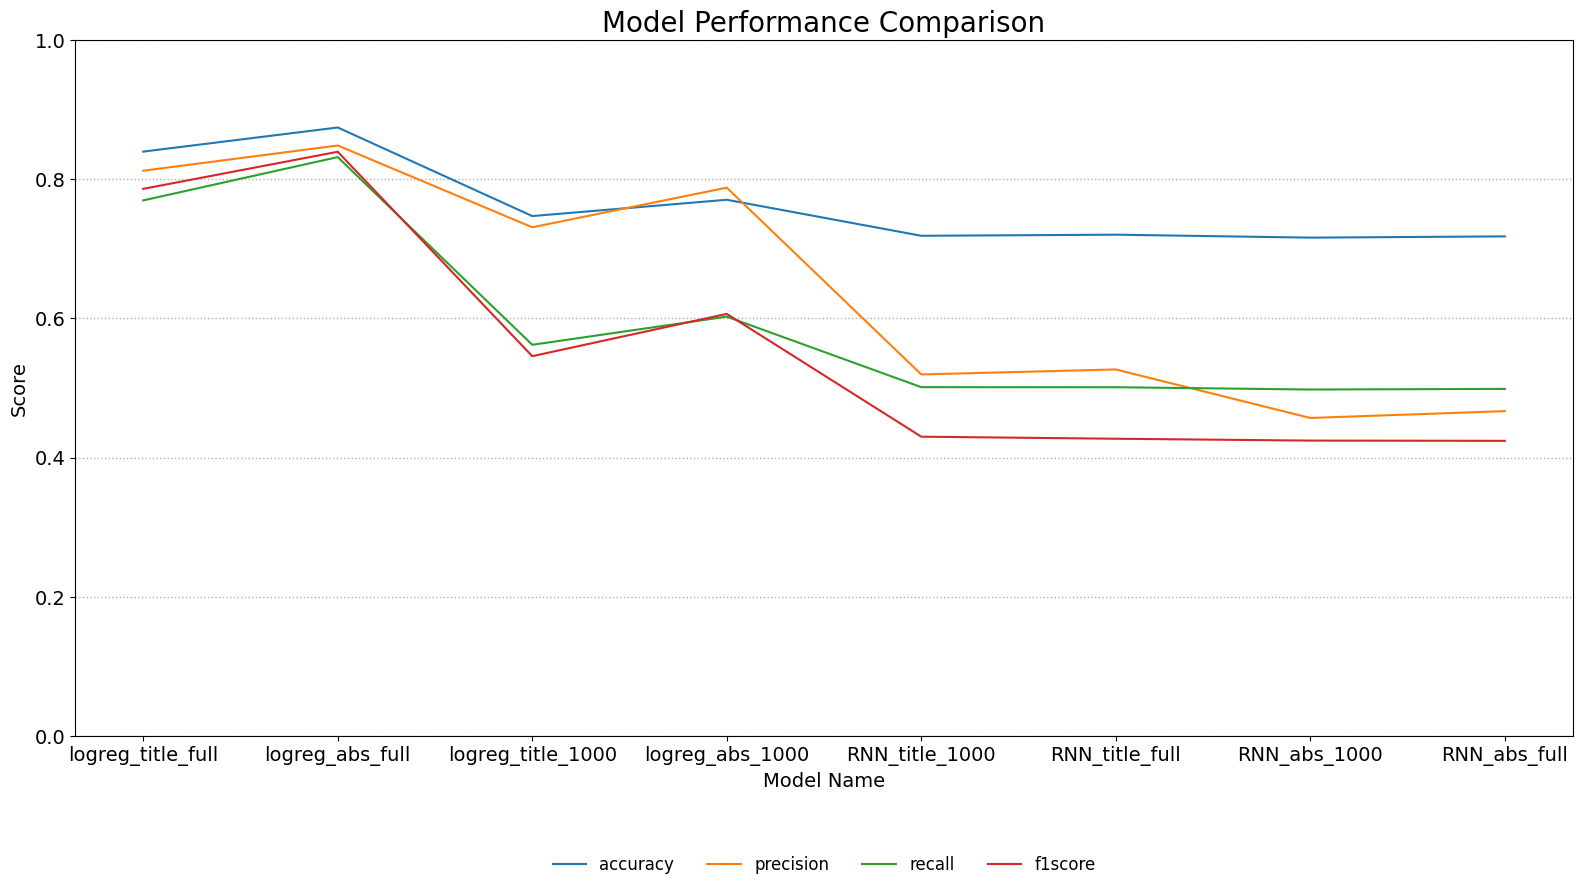

In [44]:
import matplotlib.pyplot as plt

metrics = ['accuracy', 'precision', 'recall', 'f1score']

# Create larger figure
plt.figure(figsize=(16, 9))

# Plot metric lines
cv_df.set_index('model_name')[metrics].plot(kind='line', figsize=(16, 9), legend=False)

plt.title('Model Performance Comparison', fontsize=20)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Model Name', fontsize=14)
plt.ylim(0, 1.0)
plt.xticks(rotation=0)

# Increase tick value font sizes
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(axis='y', linestyle=':', linewidth=1)

# Legend BELOW the chart
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    fontsize=12,
    frameon=False
)

plt.tight_layout()
plt.show()



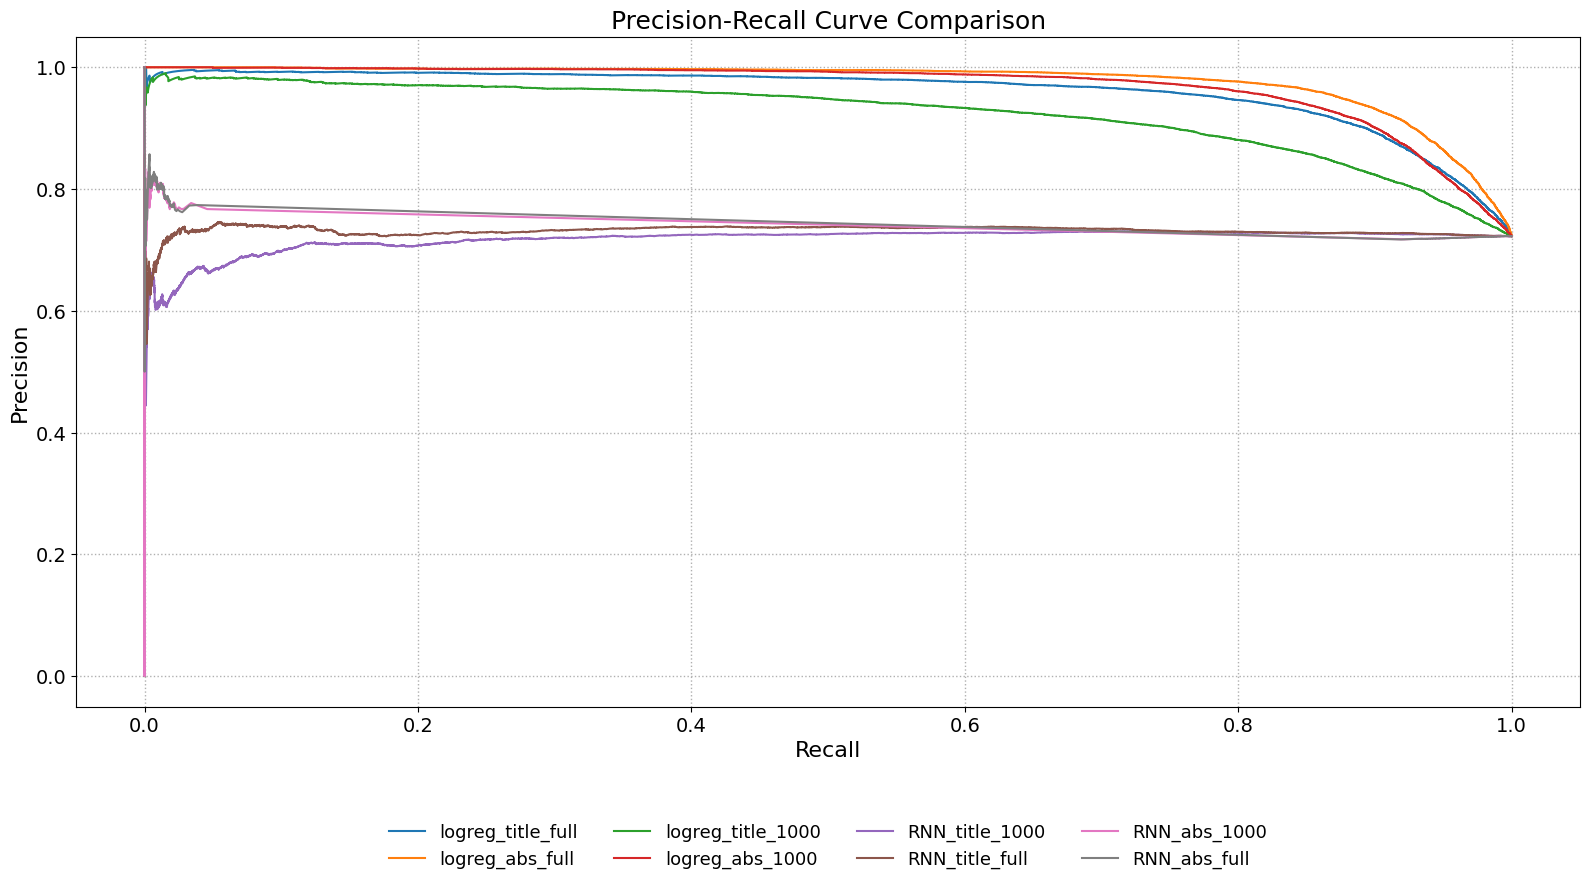

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))

# Plot PR curves
for i in range(len(cv_df)):
    model_name = cv_df.iloc[i]['model_name']
    precision = cv_df.iloc[i]['precision_curve']
    recall = cv_df.iloc[i]['recall_curve']
    plt.plot(recall, precision, label=model_name)

plt.title('Precision-Recall Curve Comparison', fontsize=18)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)

# Increase axis tick label sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, linestyle=':', linewidth=1)

# Legend BELOW the chart
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    fontsize=13,
    frameon=False
)

plt.tight_layout()
plt.show()


**1. Overall Performance Metrics (first plot):**


*   Logistic Regression with Full Data (logreg_title_full, logreg_abs_full): Strongest performers across all metrics (accuracy ≈ 0.85+, precision/recall/f1 ≈ 0.8–0.85).
*   Logistic Regression with 1000 Samples: Noticeable drop, especially with logreg_title_1000, while logreg_abs_1000 maintains better performance than the title version, which indicates abstracts seem more informative.
*   RNN Models (Title or Abstract, 1000 or Full): Poor performance across the board. F1-scores are below 0.6 even with full datasets. Indicates RNNs didn’t generalize well or were undertrained compared with logistic regression

**Key takeaway:** Logistic Regression is more robust, especially in low-data scenarios. Abstracts are generally more informative than titles in both algorithm

**2. Precision-Recall Curve (second plot):** Curves closer to the top-right indicate better precision-recall


*   logreg_title_full and logreg_abs_full have the best curves — confirming their strength from the first plot. logreg_title_1000 and logreg_abs_1000 drop but still outperform all RNN variants.
*   RNN curves (especially RNN_abs_1000, RNN_title_1000) show early steep drops in precision — they misclassify too many positives.

**Key takeaway:** RNN models fail to sustain precision as recall increases, indicating overfitting or training instability. Logistic Regression models maintain strong and consistent precision-recall trade-offs.


# **Reference**

https://medium.com/@douglaspsteen/precision-recall-curves-d32e5b290248

https://medium.com/@humble_bee/rnn-recurrent-neural-networks-lstm-842ba7205bbf